In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

In [2]:
# this is our target
y_CME3MSOFR = pd.read_csv(f"../data/CME3MSOFR.csv")
y_CME3MSOFR = y_CME3MSOFR.dropna(axis="columns")
y_CME3MSOFR.drop(columns=["dd", "mm", "yyyy"], inplace=True)
y_CME3MSOFR.columns = ["date", "y_rate_CME3MSOFR"]
y_CME3MSOFR["date"] = pd.to_datetime(y_CME3MSOFR["date"])
# flip it so that first row
y_CME3MSOFR = y_CME3MSOFR.iloc[::-1]
y_CME3MSOFR.reset_index(inplace=True)
y_CME3MSOFR = y_CME3MSOFR.drop(columns=["index"])
print(y_CME3MSOFR.head())

        date  y_rate_CME3MSOFR
0 2019-01-03            2.4328
1 2019-01-04            2.4296
2 2019-01-07            2.4276
3 2019-01-08            2.4298
4 2019-01-09            2.4390


In [3]:
# check NA
print(y_CME3MSOFR[y_CME3MSOFR.isna().any(axis=1)])
# describe the data
print(y_CME3MSOFR.describe())

Empty DataFrame
Columns: [date, y_rate_CME3MSOFR]
Index: []
       y_rate_CME3MSOFR
count       1199.000000
mean           1.821782
std            1.884534
min            0.016000
25%            0.069150
50%            1.579000
75%            2.665290
max            5.422450


In [4]:
# this is our feature
# 3MSOFRFuture
x_3MSOFRFuture = pd.read_csv(f"../data/3MSOFRFuture.csv")
x_3MSOFRFuture = x_3MSOFRFuture.dropna(axis="columns")
x_3MSOFRFuture.drop(columns=["dd", "mm", "yyyy"], inplace=True)
x_3MSOFRFuture.columns = ["date", "price_3MSOFRFuture"]
x_3MSOFRFuture["date"] = pd.to_datetime(x_3MSOFRFuture["date"])
# flip it so that first row
x_3MSOFRFuture = x_3MSOFRFuture.iloc[::-1]
x_3MSOFRFuture.reset_index(inplace=True)
x_3MSOFRFuture = x_3MSOFRFuture.drop(columns=["index"])
print(x_3MSOFRFuture.head())

        date  price_3MSOFRFuture
0 2018-12-14              97.370
1 2018-12-17              97.405
2 2018-12-18              97.455
3 2018-12-19              97.460
4 2018-12-20              97.470


In [5]:
# check NA
print(x_3MSOFRFuture[x_3MSOFRFuture.isna().any(axis=1)])
# describe the data
print(x_3MSOFRFuture.describe())

Empty DataFrame
Columns: [date, price_3MSOFRFuture]
Index: []
       price_3MSOFRFuture
count         1247.000000
mean            97.822650
std              1.834714
min             94.305000
25%             96.332500
50%             98.515000
75%             99.380000
max             99.990000


In [6]:
# this is our feature
# USTbill3M
x_USTbill3M = pd.read_csv(f"../data/USTbill3M.csv")
x_USTbill3M = x_USTbill3M.dropna(axis="columns")
x_USTbill3M.columns = ["date", "rate_USTbill3M"]
x_USTbill3M["date"] = pd.to_datetime(x_USTbill3M["date"])
# no need flip, already in correct order
print(x_USTbill3M.head())

        date  rate_USTbill3M
0 2018-11-26          2.3775
1 2018-11-27          2.3771
2 2018-11-28          2.3704
3 2018-11-29          2.3616
4 2018-11-30          2.3654


In [7]:
# check NA
print(x_USTbill3M[x_USTbill3M.isna().any(axis=1)])
# describe the data
print(x_USTbill3M.describe())

Empty DataFrame
Columns: [date, rate_USTbill3M]
Index: []
       rate_USTbill3M
count     1250.000000
mean         1.866989
std          1.902441
min         -0.031200
25%          0.090225
50%          1.556850
75%          2.700375
max          5.491500


In [8]:
# USD3MOIS this is weird data
x_USD3MOIS = pd.read_csv(f"../data/USD3MOIS.csv")
x_USD3MOIS.columns = ["date", "bid", "ask"]
x_USD3MOIS["date"] = pd.to_datetime(x_USD3MOIS["date"])
x_USD3MOIS["mid_USD3MOIS"] = 0.5 * (x_USD3MOIS["bid"] + x_USD3MOIS["ask"])
# flip it so that first row
x_USD3MOIS = x_USD3MOIS.iloc[::-1]
x_USD3MOIS = x_USD3MOIS.drop(columns=["bid", "ask"])
print(x_USD3MOIS.head())

           date  mid_USD3MOIS
1515 2018-01-02         1.439
1514 2018-01-03         1.444
1513 2018-01-04         1.454
1512 2018-01-05         1.454
1511 2018-01-08         1.457


In [9]:
to_concat = [x_3MSOFRFuture, x_USTbill3M, x_USD3MOIS]
df_concat = y_CME3MSOFR
for frames in to_concat:
    df_concat = pd.merge(df_concat, frames, on="date", how="left")
    print(df_concat.isna().sum())
print(df_concat.describe())

date                  0
y_rate_CME3MSOFR      0
price_3MSOFRFuture    0
dtype: int64
date                  0
y_rate_CME3MSOFR      0
price_3MSOFRFuture    0
rate_USTbill3M        1
dtype: int64
date                  0
y_rate_CME3MSOFR      0
price_3MSOFRFuture    0
rate_USTbill3M        1
mid_USD3MOIS          0
dtype: int64
       y_rate_CME3MSOFR  price_3MSOFRFuture  rate_USTbill3M  mid_USD3MOIS
count       1199.000000         1199.000000     1198.000000   1199.000000
mean           1.821782           97.893874        1.781852      1.831487
std            1.884534            1.801295        1.868201      1.884902
min            0.016000           94.305000       -0.031200      0.043000
25%            0.069150           96.635000        0.087600      0.081000
50%            1.579000           98.550000        1.541100      1.556000
75%            2.665290           99.392500        2.506525      2.740500
max            5.422450           99.990000        5.470100      5.442400


In [10]:
df_concat = df_concat.fillna(method="ffill")
df_concat

,date,y_rate_CME3MSOFR,price_3MSOFRFuture,rate_USTbill3M,mid_USD3MOIS
0,2019-01-03,2.43280,97.8350,2.3919,2.3930
1,2019-01-04,2.42960,97.7700,2.4058,2.4040
2,2019-01-07,2.42760,97.7250,2.4127,2.4070
3,2019-01-08,2.42980,97.6550,2.4243,2.4150
4,2019-01-09,2.43900,97.6650,2.4213,2.4100
...,...,...,...,...,...
1194,2023-11-14,5.37972,94.6500,5.4014,5.3649
1195,2023-11-15,5.39021,94.6500,5.4061,5.3686
1196,2023-11-16,5.36937,94.6500,5.3972,5.3662
1197,2023-11-17,5.36710,94.6525,5.3969,5.3696


In [11]:
# lag the features by x
lag = 1
df_concat[f"x_rate_CME3MSOFR_lag{lag}"] = df_concat["y_rate_CME3MSOFR"].shift(lag)
df_concat[f"x_price_3MSOFRFuture_lag{lag}"] = df_concat["price_3MSOFRFuture"].shift(lag)
df_concat[f"x_rate_USTbill3M_lag{lag}"] = df_concat["rate_USTbill3M"].shift(lag)
df_concat[f"x_mid_USD3MOIS_lag{lag}"] = df_concat["mid_USD3MOIS"].shift(lag)

In [12]:
df_concat.drop(
    columns=["price_3MSOFRFuture", "rate_USTbill3M", "mid_USD3MOIS"], inplace=True
)

In [13]:
df_concat.head(5)

,date,y_rate_CME3MSOFR,x_rate_CME3MSOFR_lag1,x_price_3MSOFRFuture_lag1,x_rate_USTbill3M_lag1,x_mid_USD3MOIS_lag1
0,2019-01-03,2.4328,NaN,NaN,NaN,NaN
1,2019-01-04,2.4296,2.4328,97.835,2.3919,2.393
2,2019-01-07,2.4276,2.4296,97.770,2.4058,2.404
3,2019-01-08,2.4298,2.4276,97.725,2.4127,2.407
4,2019-01-09,2.4390,2.4298,97.655,2.4243,2.415


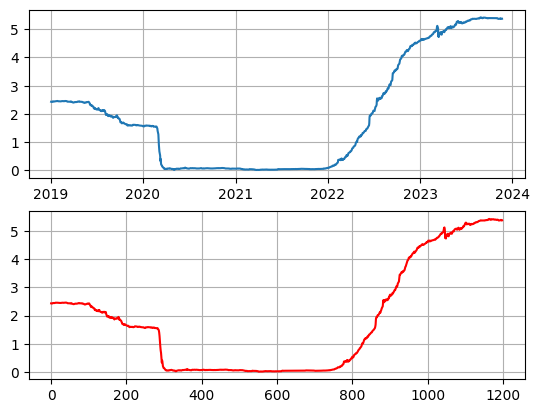

In [14]:
plt.subplot(211)
plt.plot(df_concat["date"], df_concat["y_rate_CME3MSOFR"])
plt.grid()
plt.subplot(212)
plt.plot(df_concat["y_rate_CME3MSOFR"], color="red")
plt.grid()

In [15]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Extract feature and target arrays
adfuller(df_concat["y_rate_CME3MSOFR"].dropna())

(0.09670383850432249,
 0.9658353279811982,
 19,
 1179,
 {'1%': -3.4359086044391476,
  '5%': -2.863994554693699,
  '10%': -2.5680768554093008},
 -5587.969739956731)

In [16]:
# try diff once !
df_concat["y_rate_CME3MSOFR_diff1"] = df_concat["y_rate_CME3MSOFR"].diff()
adfuller(df_concat["y_rate_CME3MSOFR_diff1"].dropna())

(-4.562389170124363,
 0.00015143610186267432,
 18,
 1179,
 {'1%': -3.4359086044391476,
  '5%': -2.863994554693699,
  '10%': -2.5680768554093008},
 -5584.174151454393)

## Markov Switching Dynamic Regression ##
https://www.statsmodels.org/dev/examples/notebooks/generated/markov_regression.html

In [17]:
# Fit the model, lets try lagged t-1 rates
mod_kns = sm.tsa.MarkovRegression(
    df_concat["y_rate_CME3MSOFR"].iloc[1:],
    k_regimes=3,
    switching_variance=True,
)
res_kns = mod_kns.fit()
res_kns.summary()

c:\Users\kilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1291: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
c:\Users\kilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1291: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
c:\Users\kilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\regime_switc

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:       y_rate_CME3MSOFR   No. Observations:                 1198
Model:               MarkovRegression   Log Likelihood                 402.193
Date:                Fri, 01 Dec 2023   AIC                           -780.386
Time:                        03:16:54   BIC                           -719.325
Sample:                             0   HQIC                          -757.383
                               - 1198                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0583      0.001     61.728      0.000       0.056       0.060
sigma2         0.0004   2.93e-05     12.996      0.000       0.000       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8392      0.038     48.577      0.000       1.765       1.913
sigma2         0.6519      0.045     14.633      0.000       0.565       0.739
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9380      0.028    178.781      0.000       4.884       4.992
sigma2         0.1742      0.018      9.824      0.000       0.139       0.209
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9973      0.007    141.948      0.000       0.984       1.011
p[1->0]        0.0016      0.002      0.959      0.338      -0.002       0.005
p[2->0]     3.452e-14      0.007   4.68e-12      1.000      -0.014       0.014
p[0->1]        0.0027      0.003      0.992      0.321      -0.003       0.008
p[1->1]        0.9971      0.002    434.571      0.000       0.993       1.002
p[2->1]        0.0014      0.004      0.350      0.727      -0.007       0.009
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

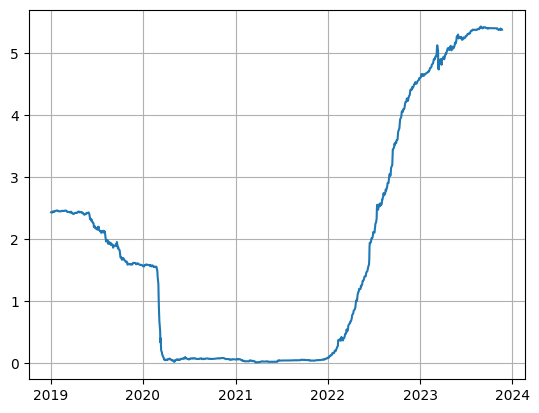

In [18]:
plt.plot(df_concat["date"], df_concat["y_rate_CME3MSOFR"])
plt.grid()

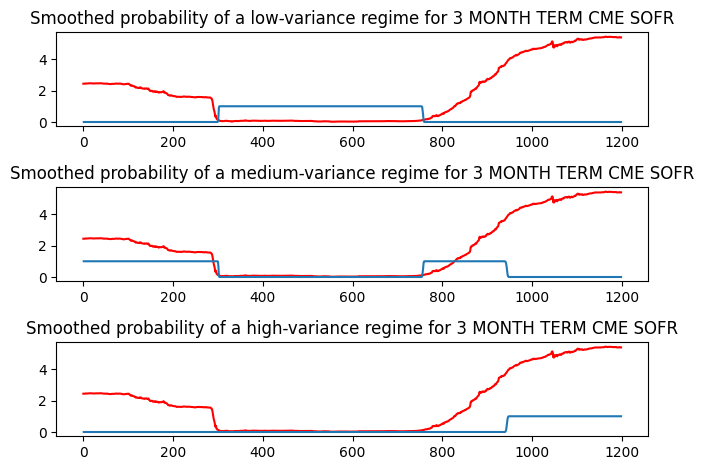

In [19]:
fig, axes = plt.subplots(3)
ax = axes[0]
ax.plot(df_concat["y_rate_CME3MSOFR"], color="red")
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title="Smoothed probability of a low-variance regime for 3 MONTH TERM CME SOFR")
ax = axes[1]
ax.plot(df_concat["y_rate_CME3MSOFR"], color="red")
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(
    title="Smoothed probability of a medium-variance regime for 3 MONTH TERM CME SOFR"
)
ax = axes[2]
ax.plot(df_concat["y_rate_CME3MSOFR"], color="red")
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title="Smoothed probability of a high-variance regime for 3 MONTH TERM CME SOFR")
fig.tight_layout()

In [20]:
print(res_kns.expected_durations)

[369.38225516 347.48006566 696.05628148]


## Simple XGBOOST ##

In [21]:
df_simple = pd.DataFrame(df_concat["y_rate_CME3MSOFR"])
df_simple["x_lagged"] = df_simple["y_rate_CME3MSOFR"].shift(1)
df_simple

,y_rate_CME3MSOFR,x_lagged
0,2.43280,NaN
1,2.42960,2.43280
2,2.42760,2.42960
3,2.42980,2.42760
4,2.43900,2.42980
...,...,...
1194,5.37972,5.37764
1195,5.39021,5.37972
1196,5.36937,5.39021
1197,5.36710,5.36937


In [22]:
X = df_simple["x_lagged"]
y = df_simple["y_rate_CME3MSOFR"]

In [23]:
X

0           NaN
1       2.43280
2       2.42960
3       2.42760
4       2.42980
         ...   
1194    5.37764
1195    5.37972
1196    5.39021
1197    5.36937
1198    5.36710
Name: x_lagged, Length: 1199, dtype: float64

In [24]:
X_train = X.iloc[:-500].to_numpy()
X_test = X.iloc[-500:].to_numpy()
y_train = y.iloc[:-500].to_numpy()
y_test = y.iloc[-500:].to_numpy()

In [25]:
X_train = np.reshape(X_train, (-1, 1))
X_test = np.reshape(X_test, (-1, 1))
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

In [26]:
reg = xgb.XGBRegressor(n_estimators=10000)
reg.fit(
    X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

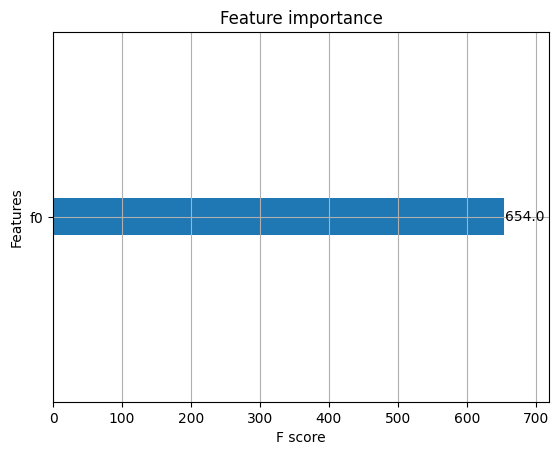

In [27]:
xgb.plot_importance(reg)

In [28]:
X_test

array([[0.05372],
       [0.0515 ],
       [0.04539],
       [0.04731],
       [0.04546],
       [0.0476 ],
       [0.04653],
       [0.04764],
       [0.04776],
       [0.04819],
       [0.04784],
       [0.04774],
       [0.04603],
       [0.04439],
       [0.04479],
       [0.04643],
       [0.0461 ],
       [0.0461 ],
       [0.04979],
       [0.05004],
       [0.0512 ],
       [0.05338],
       [0.05315],
       [0.05278],
       [0.05155],
       [0.05384],
       [0.05556],
       [0.05575],
       [0.05353],
       [0.05363],
       [0.05413],
       [0.05586],
       [0.05521],
       [0.05569],
       [0.05742],
       [0.05848],
       [0.05885],
       [0.05903],
       [0.05886],
       [0.06211],
       [0.06659],
       [0.07081],
       [0.06436],
       [0.06547],
       [0.0672 ],
       [0.07579],
       [0.07521],
       [0.07862],
       [0.07907],
       [0.08216],
       [0.09281],
       [0.09125],
       [0.0911 ],
       [0.09274],
       [0.09317],
       [0.

In [29]:
# create prediction dataframe
pred = y_test.copy()
pred_result = reg.predict(X_test)

<Axes: title={'center': 'simple XGBOOST'}>

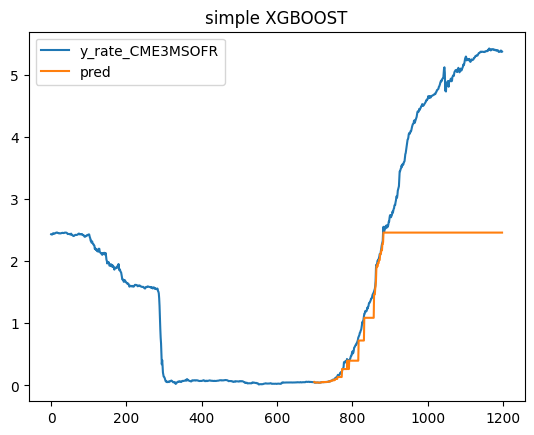

In [30]:
# hackmode use nan
result = pd.DataFrame(y)
a = np.full(len(y_train), np.nan)
a = np.append(a, pred_result)
result["pred"] = a
result.plot(title="simple XGBOOST")

In [35]:
from sklearn.metrics import mean_squared_error

# evaluate predictions
mse = mean_squared_error(pred_result, y_test)
mse

3.2858974103163456